# Discovering structure behind data

In this tutorial, we'll explore and inspect how can a model do its decisions on a car data set. Such an inspection could be used to reverse engineer the behavior of any function. Decision trees works with simple "if" clauses chained together, splitting the data flow recursively on those if until it reaches a leaf where we can categorize the data. 

Since decision trees are a good algorithm for discovering the structure hidden behind data, we'll use the car evaluation data set, for which the prediction problem is a (deterministic) surjective function. This means that the inputs of the examples in the data set cover all the possibilities, and that for each possible input value, there is only one answer to predict (thus, two examples with the same input values would never have a different expected prediction). The attribute to predict in the data set could have been, for example, created from a programmatic function and we will basically reverse engineer the logic mapping the inputs to the outputs to recreate the function. 

## About the Car Evaluation Data Set

For more information:: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

### Overview

The Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure: 

- CAR car acceptability:
  - PRICE overall price:
    - **buying** buying price
    - **maint price** of the maintenance
  - TECH technical characteristics:
    - COMFORT comfort:
      - **doors** number of doors
      - **persons** capacity in terms of persons to carry
      - **lug_boot** the size of luggage boot
    - **safety** estimated safety of the car

Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a set of examples (for these examples sets see [Web Link]). 

The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: buying, maint, doors, persons, lug_boot, safety. 

Because of known underlying concept structure, this database may be particularly useful for testing constructive induction and structure discovery methods. 

### Number of Attributes: 6

Missing Attribute Values: none

| Attribute  | Values |
|------------|--------|
| buying     | v-high, high, med, low |
| maint      | v-high, high, med, low |
| doors      | 2, 3, 4, 5-more |
| persons    | 2, 4, more |
| lug_boot   | small, med, big |
| safety     | low, med, high |

### Number of instances and Class Distribution

Number of Instances: 1728

(Instances completely cover the attribute space.)

| class | N | N[%] |
|---|---|---|
| unacc | 1210 | 70.023 % |
| acc | 384 | 22.222 % |
| good | 69 | 3.993 % |
| v-good | 65 | 3.762 % |

## Let's download the data: 

In [1]:
!cat download_data.sh
!./download_data.sh

wget http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.c45-names
wget http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
wget http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.names

--2017-07-04 17:39:17--  http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.c45-names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276 [text/plain]
Saving to: ‘car.c45-names’

car.c45-names       100%[===================>]     276  --.-KB/s    in 0s      

2017-07-04 17:39:17 (45,8 MB/s) - ‘car.c45-names’ saved [276/276]

--2017-07-04 17:39:17--  http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP re

## We'll now load the car evaluation data set in Python and then train decision trees

Let's first import all what we need:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import os

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Define the features and preprocess the car evaluation data set

In [3]:
output_labels = ["unacc", "acc", "good", "vgood"]

input_labels = [
    ["buying", ["vhigh", "high", "med", "low"]],
    ["maint", ["vhigh", "high", "med", "low"]],
    ["doors", ["2", "3", "4", "5more"]],
    ["persons", ["2", "4", "more"]],
    ["lug_boot", ["small", "med", "big"]],
    ["safety", ["low", "med", "high"]],
]

attrs_names = []
for a in input_labels:
    key = a[0]
    for b in a[1]:
        value = b
        attrs_names.append("{}_is_{}".format(key, value))

print("Name of input attributes for the plot to be built:")
print(attrs_names)

# Load data set
data = np.genfromtxt('car.data', delimiter=',', dtype="U")
# all_possible_labels = [set(l) for l in data.transpose()]

def str_data_to_one_hot(data):
    # To int
    X_int = LabelEncoder().fit_transform(data.ravel()).reshape(*data.shape)
    # To one-hot (binary)
    X_bin = OneHotEncoder().fit_transform(X_int).toarray()
    return X_bin

one_hot_data = str_data_to_one_hot(data)

X = one_hot_data[:, :len(attrs_names)]
Y = one_hot_data[:, len(attrs_names):]

# Y needs not to be one-hot:
integer_y = np.argmax(np.eye(Y.shape[-1])[np.array(np.argmax(Y, axis=1), dtype=np.uint8)], axis=1).reshape(-1, 1)

print("Data set's shape:")
print(one_hot_data.shape, X.shape, Y.shape, integer_y.shape, len(attrs_names), len(output_labels))

# Shaping the data into a single pandas dataframe for naming columns:
pdtrain = pd.DataFrame(X)
pdtrain.columns = attrs_names
dtrain = xgb.DMatrix(pdtrain, integer_y)

Name of input attributes for the plot to be built:
['buying_is_vhigh', 'buying_is_high', 'buying_is_med', 'buying_is_low', 'maint_is_vhigh', 'maint_is_high', 'maint_is_med', 'maint_is_low', 'doors_is_2', 'doors_is_3', 'doors_is_4', 'doors_is_5more', 'persons_is_2', 'persons_is_4', 'persons_is_more', 'lug_boot_is_small', 'lug_boot_is_med', 'lug_boot_is_big', 'safety_is_low', 'safety_is_med', 'safety_is_high']
Data set's shape:
(1728, 25) (1728, 21) (1728, 4) (1728, 1) 21 4


### Train simple decision trees (here using XGBoost) to fit the data set:

First, let's define some hyperparameters, such as the depth of the tree.

In [4]:

num_rounds = 1  # Do not use boosting for now, we want only 1 decision tree per class.
num_classes = len(output_labels)
num_trees = num_rounds * num_classes

# Let's use a max_depth of 4 for the sole goal of simplifying the visual representation produced
# (ideally, a tree would be deeper to classify perfectly on that dataset)
param = {
    'max_depth': 4,
    'objective': 'multi:softprob',
    'num_class': num_classes
}

bst = xgb.train(param, dtrain, num_boost_round=num_rounds)
print("Decision trees trained!")
print("Mean Error Rate:")
print(bst.eval(dtrain))

Decision trees trained!
Mean Error Rate:
b'[0]\teval-merror:0.165509'


### Plot and save the trees (one for each class):

The 4 trees of the classifer (one tree per class) will each output a number that represents how much it is probable that the thing to classify belongs to that class, and it is by comparing the output at the end of all the trees for a given example that we could get the maximal output as associating the example to that class.  Indeed, the binary situation where we have only one tree that outputs a positive and else negative number would be simpler to interpret rather than classifying for 4 binary classes at once. 

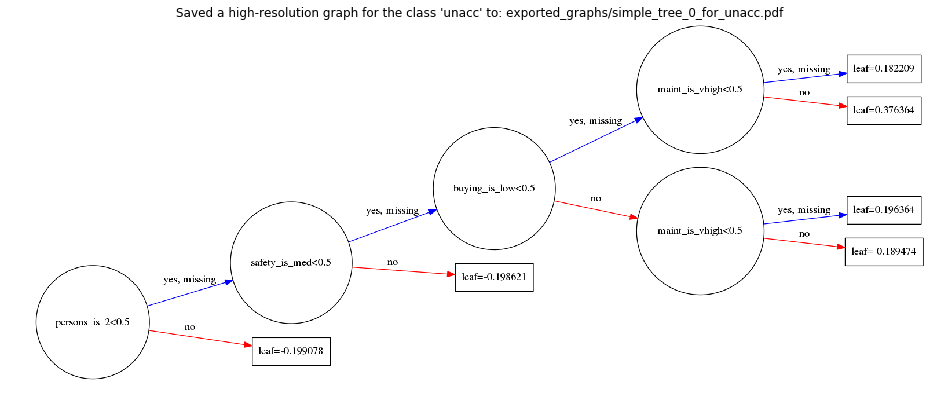

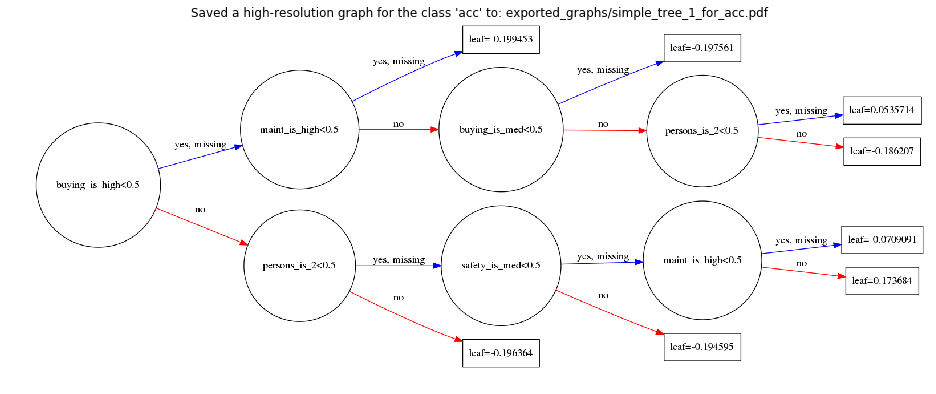

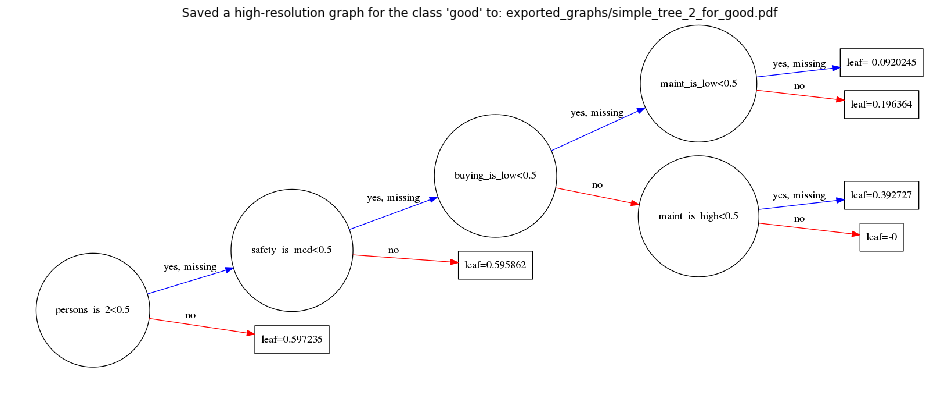

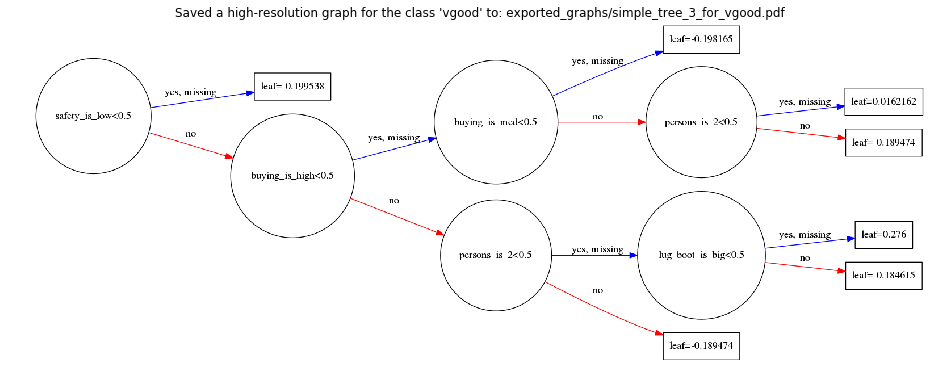

In [5]:
def plot_first_trees(bst, output_labels, trees_name):
    """
    Plot and save the first trees for multiclass classification
    before any boosting was performed.
    """
    for tree_idx in range(len(output_labels)):
        class_name = output_labels[tree_idx]
        graph_save_path = os.path.join(
            "exported_graphs", 
            "{}_{}_for_{}".format(trees_name, tree_idx, class_name)
        )

        graph = xgb.to_graphviz(bst, num_trees=tree_idx)
        graph.render(graph_save_path)

        # from IPython.display import display
        # display(graph)
        ### Inline display in the notebook would be too huge and would require much side scrolling.
        ### So we rather plot it anew with matplotlib and a fixed size for inline quick view purposes:
        fig, ax = plt.subplots(figsize=(16, 16)) 
        plot_tree(bst, num_trees=tree_idx, rankdir='LR', ax=ax)
        plt.title("Saved a high-resolution graph for the class '{}' to: {}.pdf".format(class_name, graph_save_path))
        plt.show()

# Plot our simple trees:
plot_first_trees(bst, output_labels, trees_name="simple_tree")

### Plot the importance of each input features for those simple decision trees:

Note here that it is the feature importance according to our simple, shallow trees. More complex trees would include more of the features/attributes with different proportions. 

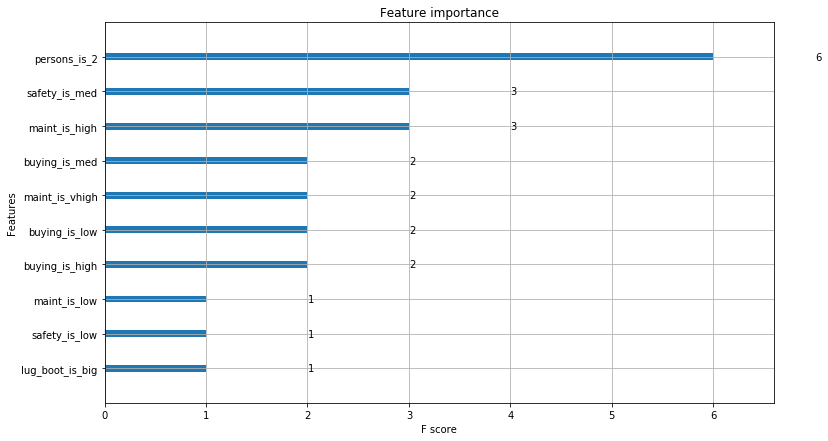

In [6]:
fig, ax = plt.subplots(figsize=(12, 7)) 
xgb.plot_importance(bst, ax=ax)
plt.show()

### Let's now generate slightly more complex trees to aid inspection

However, those trees are not maximally complex to keep things simple.

In [7]:
num_rounds = 1  # Do not use boosting for now, we want only 1 decision tree per class.
num_classes = len(output_labels)
num_trees = num_rounds * num_classes

# Let's use a max_depth of 4 for the sole goal of simplifying the visual representation produced
# (ideally, a tree would be deeper to classify perfectly on that dataset)
param = {
    'max_depth': 9,
    'objective': 'multi:softprob',
    'num_class': num_classes
}

bst = xgb.train(param, dtrain, num_boost_round=num_rounds)
print("Decision trees trained!")
print("Mean Error Rate:")
print(bst.eval(dtrain))

Decision trees trained!
Mean Error Rate:
b'[0]\teval-merror:0.026042'


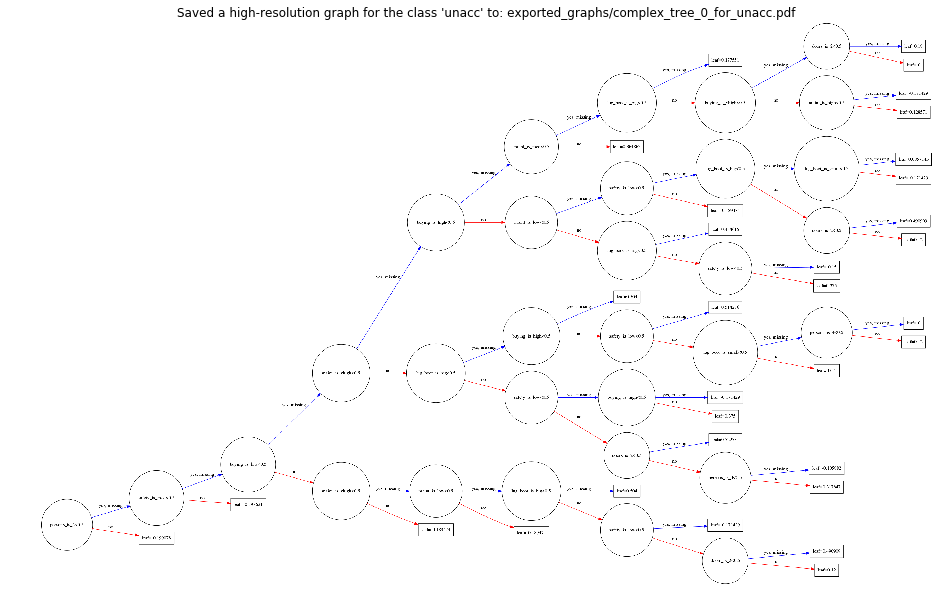

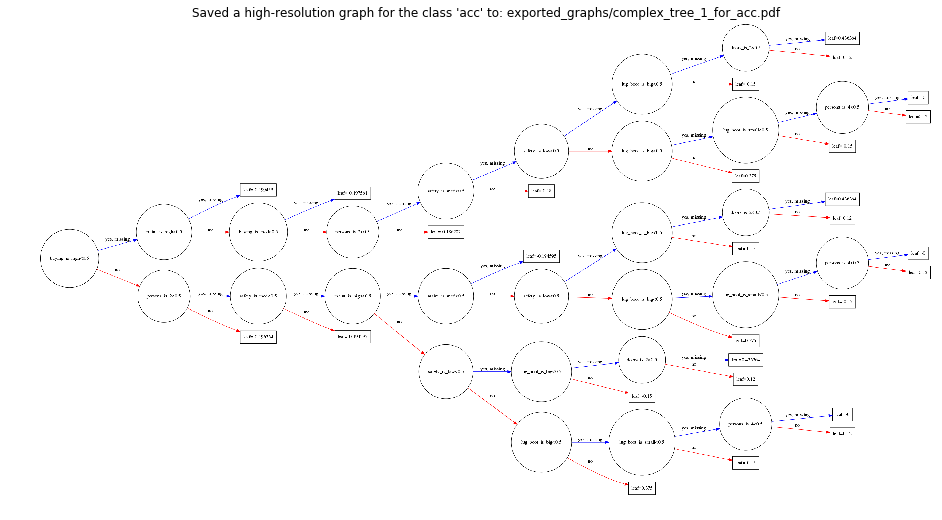

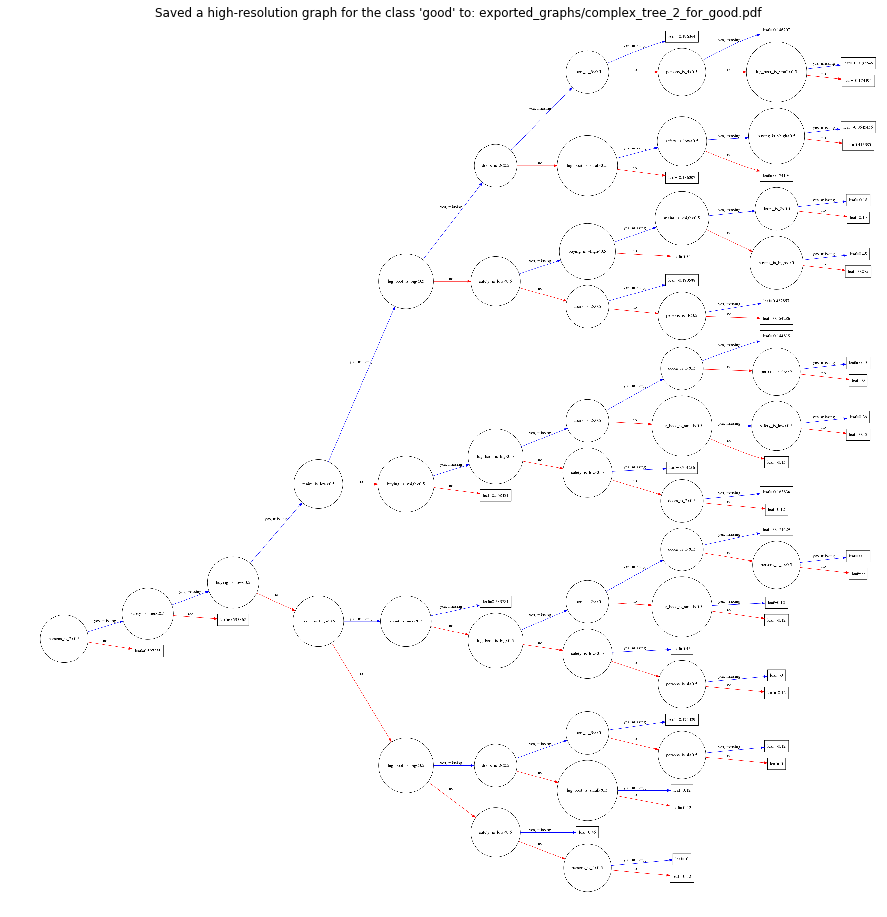

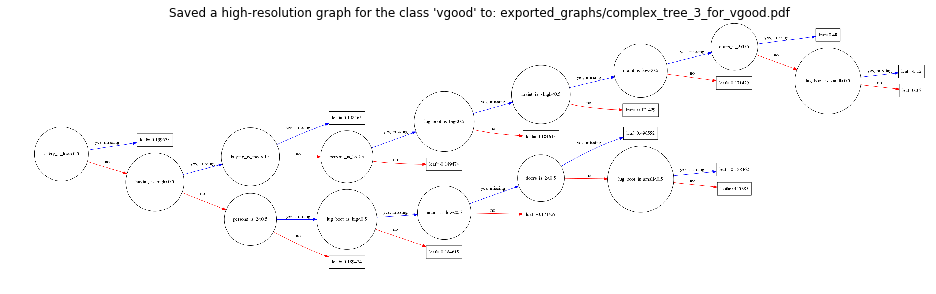

Now, our feature importance chart considers more features, but it is still not complete.


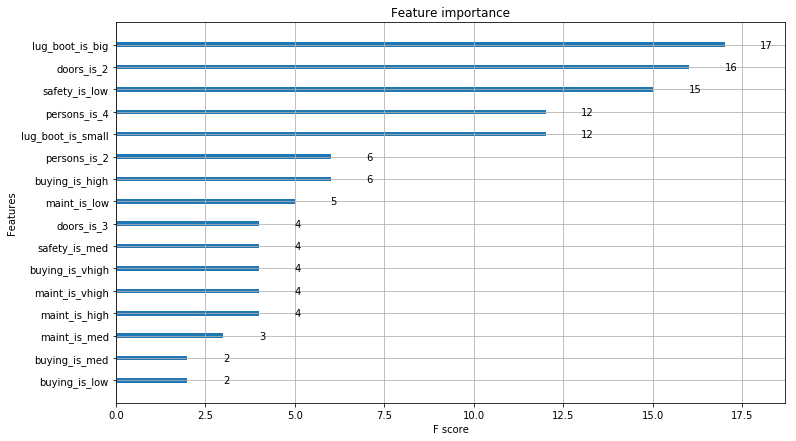

In [8]:
# Plot our complex trees:
plot_first_trees(bst, output_labels, trees_name="complex_tree")

# And their feature importance:
print("Now, our feature importance chart considers more features, but it is still not complete.")
fig, ax = plt.subplots(figsize=(12, 7)) 
xgb.plot_importance(bst, ax=ax)
plt.show()

## Conclusion

To sum up, we achieved to not only get a good classification result, but to also explain the results of the classification visually and automatically. Here, we did classification (so we requred 4 trees - one for each class), but also note that it would have been possible to solve a regression problem, too. Decision trees are also robust to numeric inputs and outputs (such as floats). As an improvement to this project, it would have been possible to take advantage of the fact we had integers for some attributes in our data set. 

Such a technique would be useful in reverse engineering an existing system, such as an old one that has been coded in a peculiar programming language and for which the employees who coded that have left. This technique can also be used for data mining and gaining business intelligence, insights from data. 

It is very good to model datasets and it has revealed to be a <a link="http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/">quite good algorithm for winning Kaggle competitions</a>. XGBoost is normally used for boosting trees (also called gradient boosting). That is, averaging many trees (each with an importance weight) until the trees cover the complete possibilities - and each tree is trained on the errors of the previous ones until the error gets at its lowest. In our case, it would be possible to have an error of 0 since we have a dataset that represents a deterministic pure function. Using XGBoost can lead to great results in plus of being interesting for roughly explaining how classifications are made on data.

In [9]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown Decision-Trees-For-Knowledge-Discovery.ipynb
!mv Decision-Trees-For-Knowledge-Discovery.md README.md

[NbConvertApp] Converting notebook Decision-Trees-For-Knowledge-Discovery.ipynb to markdown
[NbConvertApp] Support files will be in Decision-Trees-For-Knowledge-Discovery_files/
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Writing 14902 bytes to Decision-Trees